
<span style="font-size: 35px;">GR5243 APPLIED DATA SCIENCE</span>  

<span style="font-size: 25px;">Project 1: What made you happy today?</span>    

<span style="font-size: 18px;">Tianyi Xia tx2244</span>

# Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
import string
from wordcloud import WordCloud

# Import Data

In [2]:
url = 'https://raw.githubusercontent.com/rit-public/HappyDB/master/happydb/data/cleaned_hm.csv'
df_clean = pd.read_csv(url)
df_clean.head()

hmid   wid reflection_period  \
0  27673  2053               24h   
1  27674     2               24h   
2  27675  1936               24h   
3  27676   206               24h   
4  27677  6227               24h   

                                         original_hm  \
0  I went on a successful date with someone I fel...   
1  I was happy when my son got 90% marks in his e...   
2       I went to the gym this morning and did yoga.   
3  We had a serious talk with some friends of our...   
4  I went with grandchildren to butterfly display...   

                                          cleaned_hm  modified  num_sentence  \
0  I went on a successful date with someone I fel...      True             1   
1  I was happy when my son got 90% marks in his e...      True             1   
2       I went to the gym this morning and did yoga.      True             1   
3  We had a serious talk with some friends of our...      True             2   
4  I went with grandchildren to butterfly display...      True             1   

  ground_truth_category predicted_category  
0                   NaN          affection  
1                   NaN          affection  
2                   NaN           exercise  
3               bonding            bonding  
4                   NaN          affection

In [3]:
url = 'https://raw.githubusercontent.com/megagonlabs/HappyDB/master/happydb/data/demographic.csv'
df_demo = pd.read_csv(url)
df_demo.head()

wid   age country gender  marital parenthood
0    1  37.0     USA      m  married          y
1    2  29.0     IND      m  married          y
2    3    25     IND      m   single          n
3    4    32     USA      m  married          y
4    5    29     USA      m  married          y

In [4]:
url = 'https://raw.githubusercontent.com/rit-public/HappyDB/master/happydb/data/vad.csv'
df_vad = pd.read_csv(url)
df_vad.head()

hmid   valency  dominance   arousal
0  31526  6.614000   5.840000  3.750000
1  37050  5.663158   5.461579  3.983947
2  46196  5.440000   5.364000  4.661500
3  50108       NaN        NaN       NaN
4  55093  6.195714   5.657143  4.118571

In [5]:
topic_dict = dict()
for i in ['entertainment','exercise','family','food','people','school','work','shopping','pets']:
    tem=pd.read_csv('https://raw.githubusercontent.com/rit-public/HappyDB/master/happydb/data/topic_dict/{}-dict.csv'.format(i),header = None)
    topic_dict[i] = tem[0].tolist()

In [6]:
df=pd.merge(df_clean, df_demo, on='wid')
df=pd.merge(df,df_vad, on='hmid')
df=df.drop_duplicates()
df.shape

(100535, 17)

# Sentimental Analysis

## Sentimental Analysis-Based on overall data
The overall normal distribution of 'valency', 'dominance', and 'arousal' values can be attributed to several key factors:

**1.Averaging Effects:**  
These values are often derived by aggregating individual ratings or assessments, leading to a smoothing effect that tends to produce distributions resembling a normal curve.

**2.Central Limit Theorem (CLT):**  
According to the CLT, the distribution of sample means approaches a normal distribution as the sample size increases, even if the population distribution is non-normal. Since these values are often calculated from large datasets or aggregated responses, they tend to approximate a normal distribution.

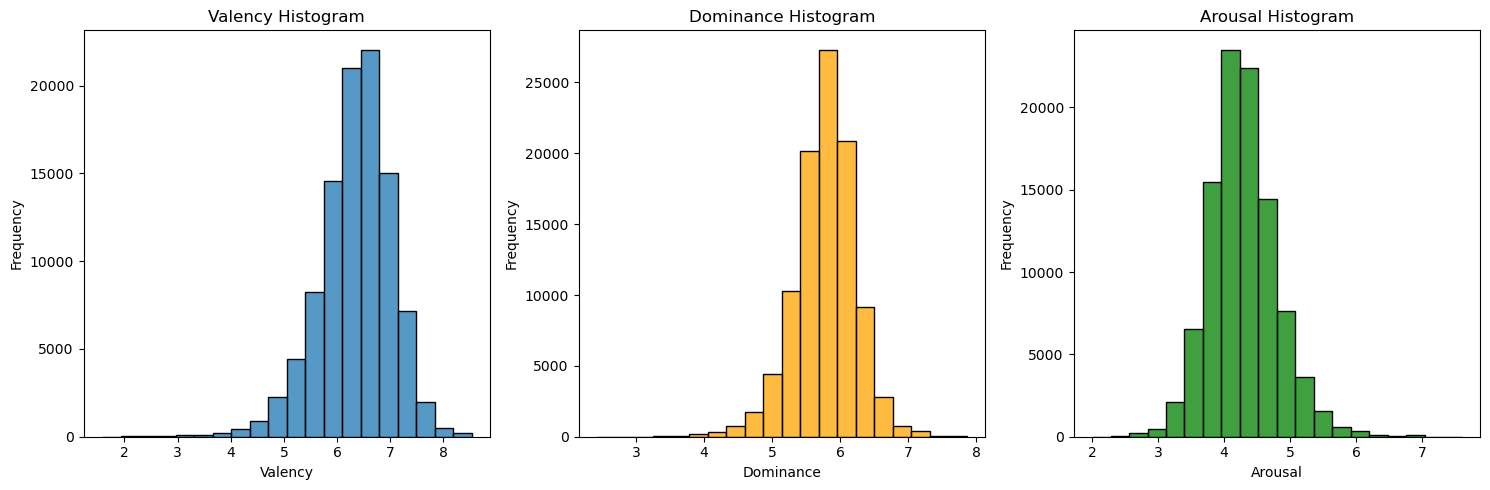

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 'valency' Hist
sns.histplot(df['valency'], bins=20, ax=axes[0])
axes[0].set_title('Valency Histogram')
axes[0].set_xlabel('Valency')
axes[0].set_ylabel('Frequency')

# 'dominance' Hist
sns.histplot(df['dominance'], bins=20, ax=axes[1], color='orange')
axes[1].set_title('Dominance Histogram')
axes[1].set_xlabel('Dominance')
axes[1].set_ylabel('Frequency')

# 'arousal' Hist
sns.histplot(df['arousal'], bins=20, ax=axes[2], color='green')
axes[2].set_title('Arousal Histogram')
axes[2].set_xlabel('Arousal')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join('../figs', 'Sentimental Analysis Histogram'), dpi=300, bbox_inches='tight')
plt.show()

## Analysis of 'valency', 'dominance', and 'approximate' for different marital status groups
**1.Single:**  
Individuals who are single may experience higher levels of independence and freedom. They might focus more on personal growth and career advancement. In terms of emotional valency, singles may have relatively high scores as they have the flexibility to engage in various social activities and pursue their interests. However, their arousal levels might be lower due to the lack of a stable romantic relationship, which can sometimes lead to feelings of loneliness or uncertainty.

**2.Married:**  
Married individuals may experience emotional stability and satisfaction due to having a committed partner and family. Their emotional valency could be high as they have a supportive and understanding spouse. Additionally, their dominance and arousal levels may be influenced by family responsibilities and societal expectations, potentially resulting in relatively high scores.

**3.Divorced:**  
Those who are divorced might have gone through emotional struggles and feelings of loss as their marriage ended. Their emotional valency may have been impacted, but they may seek new ways to rebuild their lives. Their dominance and arousal levels could fluctuate as they readjust to single life and navigate new challenges.

**4.Widowed:**  
Widowed individuals may experience profound emotional loss and grief following the death of a spouse. Their emotional valency may be lower, but they may find solace in memories and honoring their deceased partner. Their dominance and arousal levels might vary as they cope with loneliness and grief.

**5.Separated:**  
Individuals who are separated may face emotional instability as they live apart from their spouse but their marriage hasn't officially ended. They might experience similar emotional challenges as those who are divorced but may still hold onto hope and expectations for reconciliation.

In these scenarios, personal characteristics, life experiences, and coping mechanisms can influence individuals' levels of emotional valency, dominance, and arousal. For instance, married individuals may experience greater emotional stability due to family support, while single individuals may feel more freedom but also loneliness. These factors contribute to the varying average levels of valency, dominance, and arousal observed across different marital statuses.

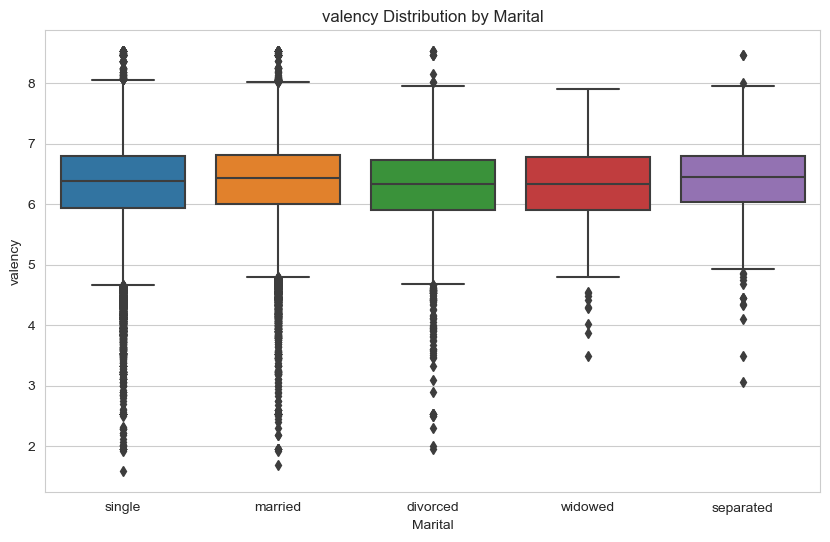

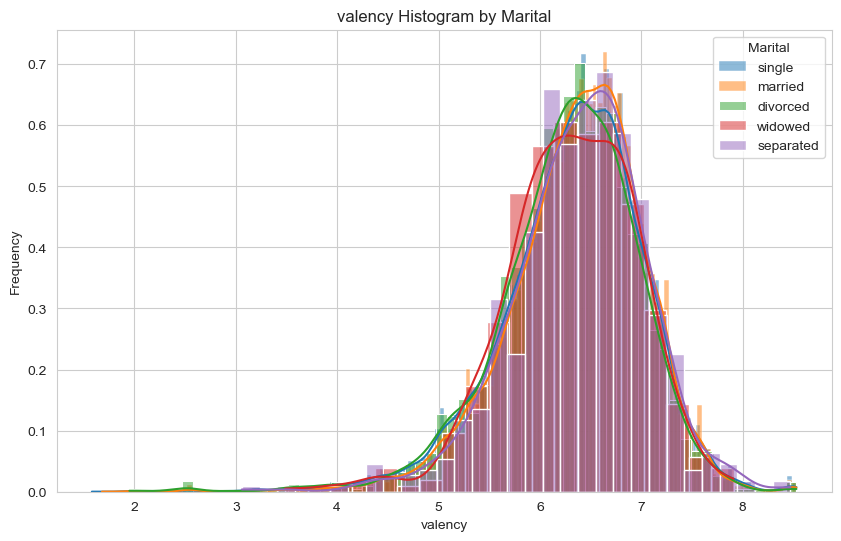

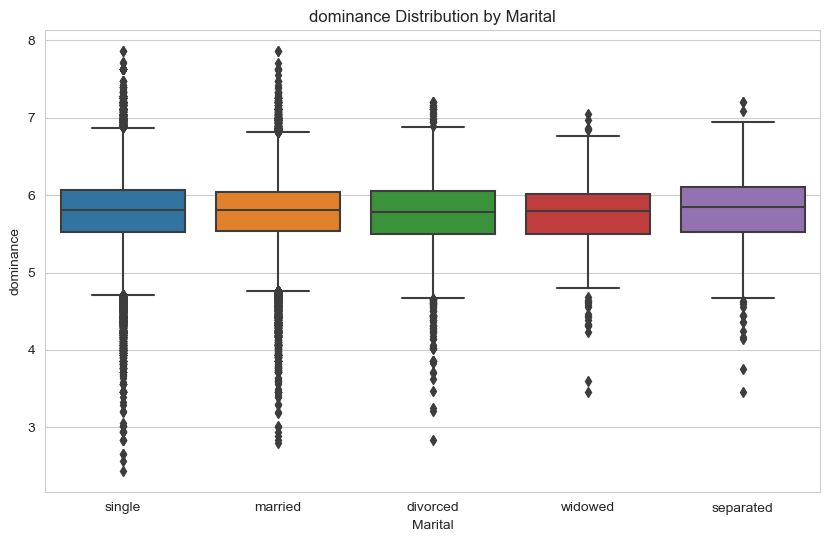

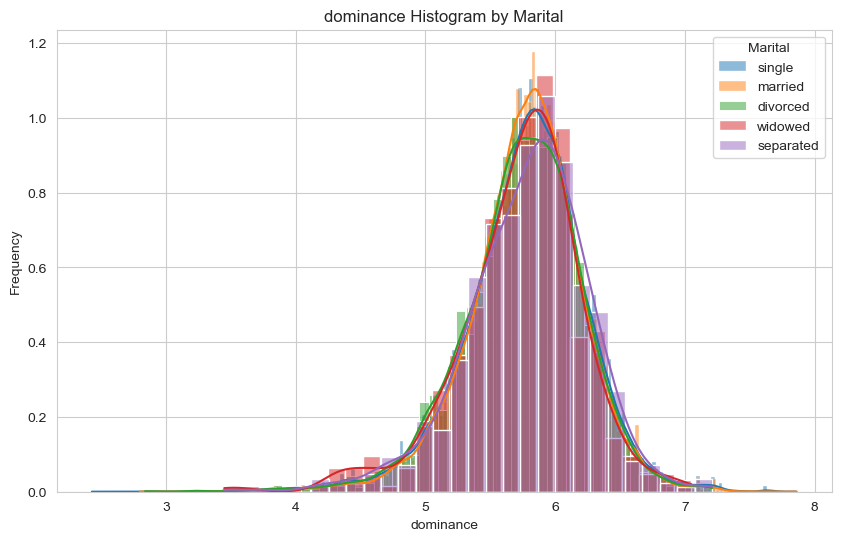

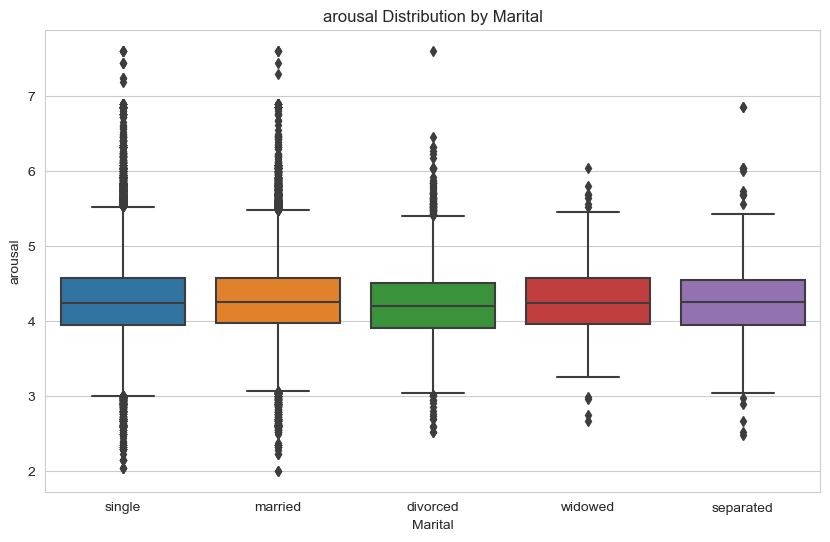

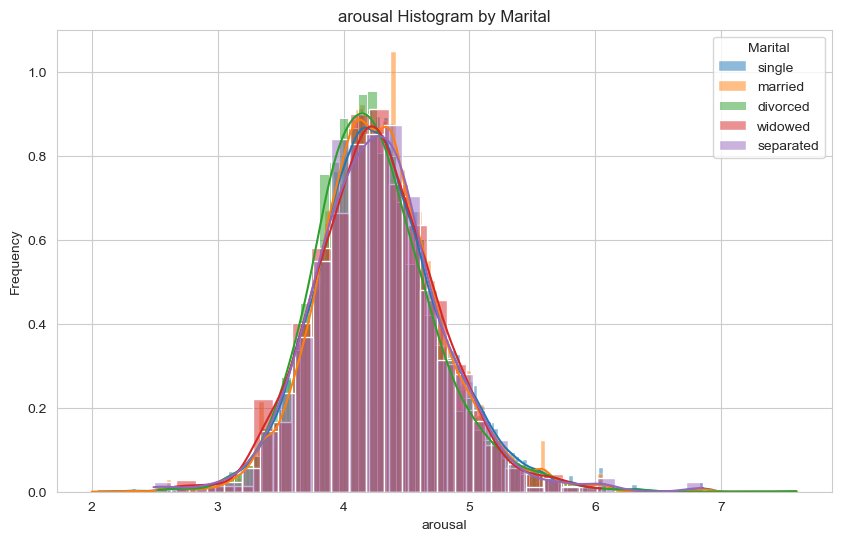

In [8]:
for i in ['valency', 'dominance', 'arousal']:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='marital', y='{}'.format(i))
    plt.title('{} Distribution by Marital'.format(i))
    plt.xlabel('Marital')
    plt.ylabel('{}'.format(i))
    plt.savefig(os.path.join('../figs', '{} Distribution by Marital'.format(i)), dpi=300, bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(10, 6))
    for j in list(df['marital'].unique()):
        sns.histplot(df[df['marital']=='{}'.format(j)]['{}'.format(i)], kde=True, label='{}'.format(j), stat='density')
    plt.title('{} Histogram by Marital'.format(i))
    plt.xlabel('{}'.format(i))
    plt.ylabel('Frequency')
    plt.legend(title='Marital')
    plt.savefig(os.path.join('../figs', '{} Histogram by Marital'.format(i)), dpi=300, bbox_inches='tight')
    plt.show()

# Analysis on topics

Pre processing steps for cleaning, word segmentation, removing stop words, stem extraction, or word form restoration

In [9]:
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
stop_words.add('happy')
df['tokens']=df['cleaned_hm'].apply(word_tokenize)
df['f_tokens']=df['tokens'].apply(lambda tokens: list(filter(lambda word: word.lower() not in (stop_words|punctuations), tokens)))

Segmenting sentences describing happiness and categorizing words

In [10]:
def count_words_in_dict(row):
    # store counts for each category
    word_counts = {}
    # Traverse each category of vocabulary in the dictionary and its corresponding vocabulary list
    for category, words in topic_dict.items():
        count = 0
        for word in row['f_tokens']:
            if word in words:
                count += 1
        word_counts[category] = count
    return word_counts
df['word_counts'] = df.apply(lambda row: count_words_in_dict(row), axis=1)

df_counts = pd.DataFrame(df['word_counts'].tolist(), index=df.index)
df = pd.concat([df, df_counts], axis=1)
df = df.drop(columns=['word_counts'])
df.to_csv(os.path.join('../output', 'processed_data.csv'), index=False)
df.head()

hmid   wid reflection_period  \
0  27673  2053               24h   
1  27873  2053               24h   
2  28073  2053               24h   
3  33522  2053               24h   
4  34522  2053               24h   

                                         original_hm  \
0  I went on a successful date with someone I fel...   
1  I played a new game that was fun and got to en...   
2  I listened to some music and heard an entire a...   
3                 Went to see a movie with my friend   
4               Played guitar, learning a song on it   

                                          cleaned_hm  modified  num_sentence  \
0  I went on a successful date with someone I fel...      True             1   
1  I played a new game that was fun and got to en...      True             1   
2  I listened to some music and heard an entire a...      True             1   
3                 Went to see a movie with my friend      True             1   
4               Played guitar, learning a song on it      True             1   

  ground_truth_category predicted_category age  ...  \
0                   NaN          affection  35  ...   
1                   NaN            leisure  35  ...   
2                   NaN            leisure  35  ...   
3                   NaN            bonding  35  ...   
4                   NaN            leisure  35  ...   

                                            f_tokens entertainment exercise  \
0  [went, successful, date, someone, felt, sympat...             0        0   
1    [played, new, game, fun, got, enjoy, mechanics]             0        0   
2  [listened, music, heard, entire, album, n't, h...             2        0   
3                         [Went, see, movie, friend]             1        0   
4                   [Played, guitar, learning, song]             1        0   

  family  food  people  school work shopping  pets  
0      0     0       1       0    0        0     0  
1      0     0       0       0    0        0     0  
2      0     0       0       0    0        0     0  
3      0     0       1       0    0        0     0  
4      0     0       0       0    0        0     0  

[5 rows x 28 columns]

**1.Relevance and Association:**   
Certain topics naturally align with specific categories. For example, topics related to family, relationships, and emotional connections are prevalent in the "affection" category, while themes of fitness, health, and physical activity dominate the "exercise" category. This suggests that individuals gravitate towards topics that resonate with the overarching theme of each category.

**2.Lifestyle and Interests:**   
Individuals' lifestyles and interests play a significant role in determining the frequency of topics within categories. Leisure-oriented categories may feature topics related to entertainment and relaxation, reflecting individuals' pursuit of enjoyment and downtime. Conversely, categories focused on achievement may highlight topics associated with career success and personal growth, reflecting individuals' aspirations and ambitions.

**3.Sociocultural Influences:**  
Sociocultural factors shape the conversation and dictate the prevalence of certain topics within categories. Cultural values, societal norms, and community practices influence individuals' interests and priorities. Consequently, topics that hold cultural significance or societal relevance may emerge more frequently within specific categories, reflecting the broader sociocultural landscape.

**4.Personal Experiences and Emotional States:**  
Individual experiences and emotional states also influence topic frequency. Happy moments may be characterized by topics associated with joy, celebration, and meaningful interactions, while stressful situations may evoke discussions around challenges, resilience, and coping strategies. Therefore, the prevalence of topics within categories reflects individuals' emotional responses and adaptive mechanisms in navigating life's complexities.

In summary, the frequency of topics within categories reflects a dynamic interplay of individual preferences, societal norms, cultural dynamics, and emotional experiences, providing valuable insights into the diverse dimensions of human life and interaction.

C:\Users\10168\AppData\Local\Temp\ipykernel_12672\657828276.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


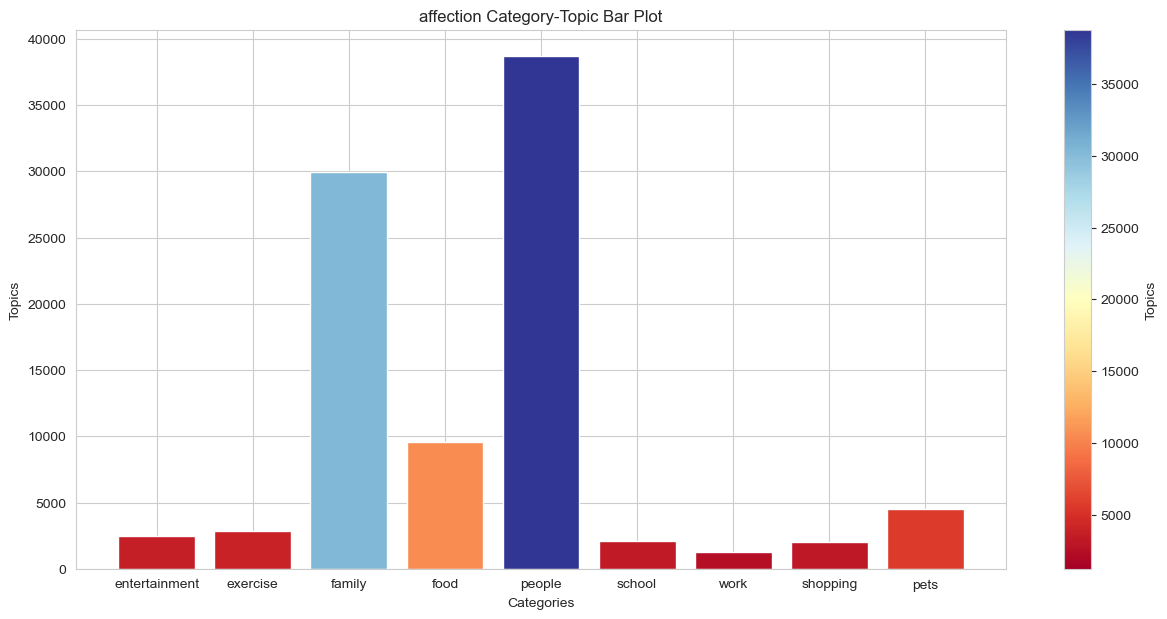

C:\Users\10168\AppData\Local\Temp\ipykernel_12672\657828276.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


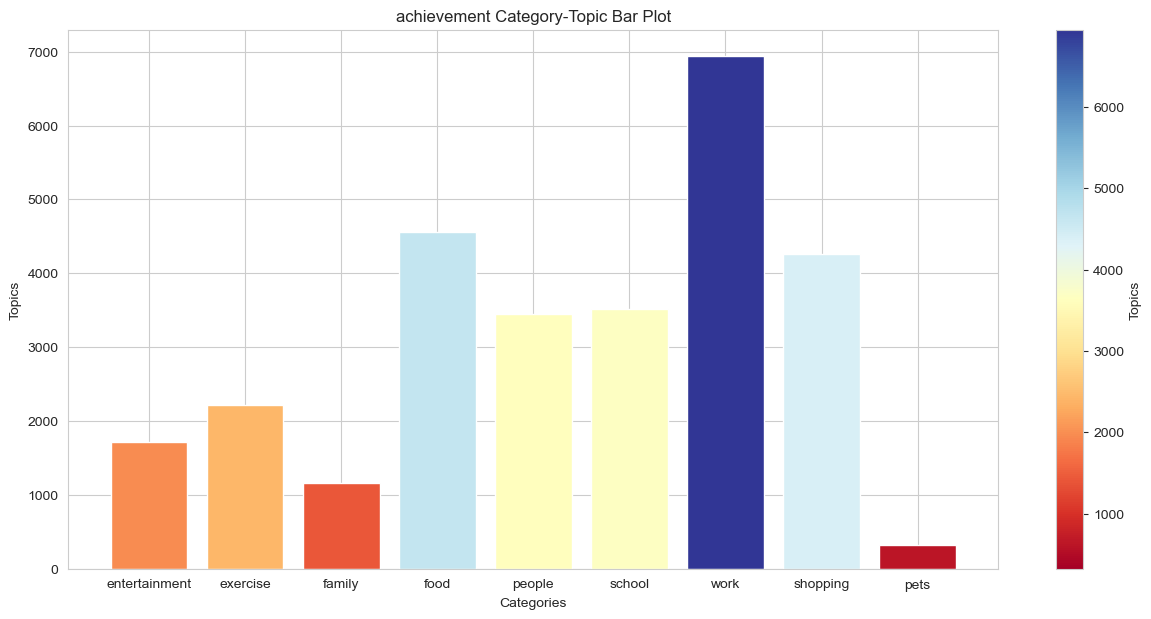

C:\Users\10168\AppData\Local\Temp\ipykernel_12672\657828276.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


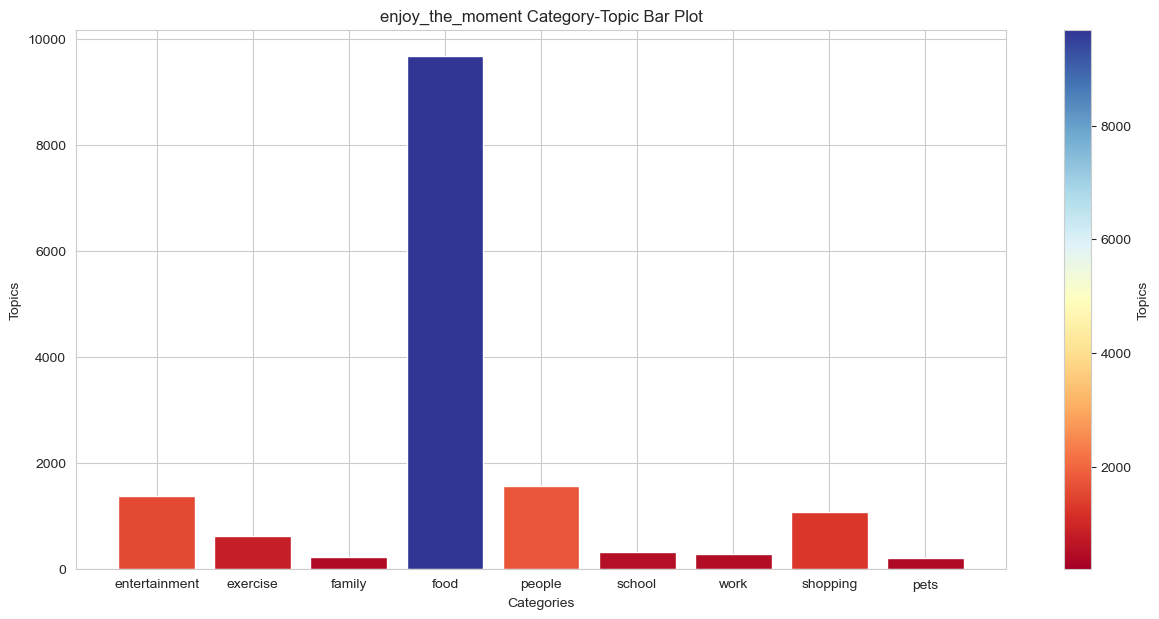

C:\Users\10168\AppData\Local\Temp\ipykernel_12672\657828276.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


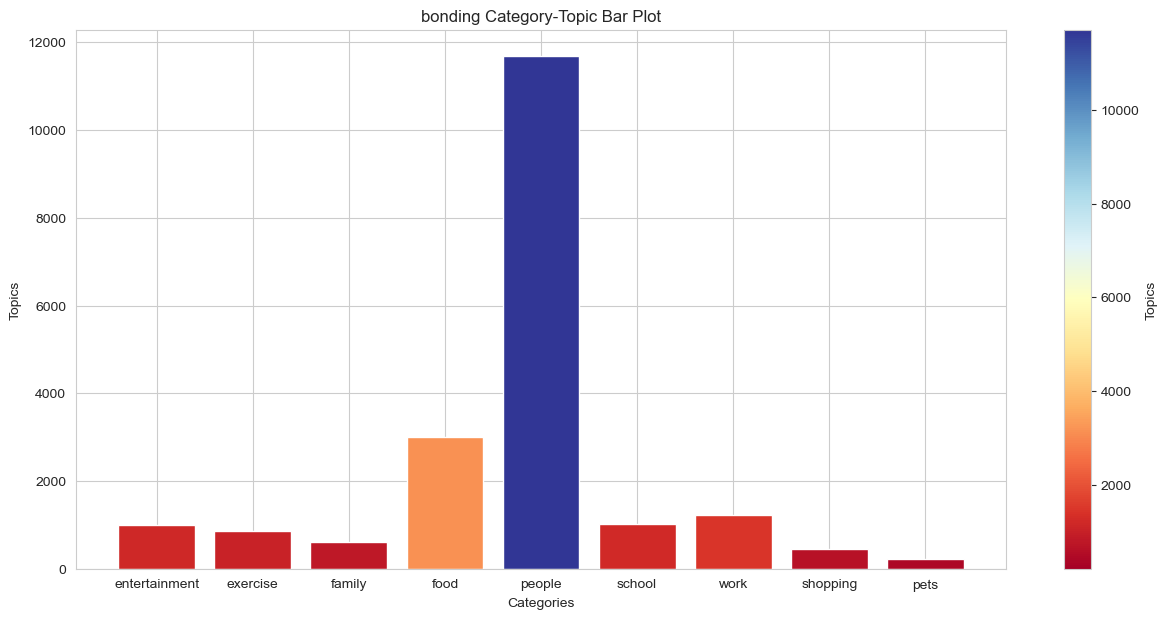

C:\Users\10168\AppData\Local\Temp\ipykernel_12672\657828276.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


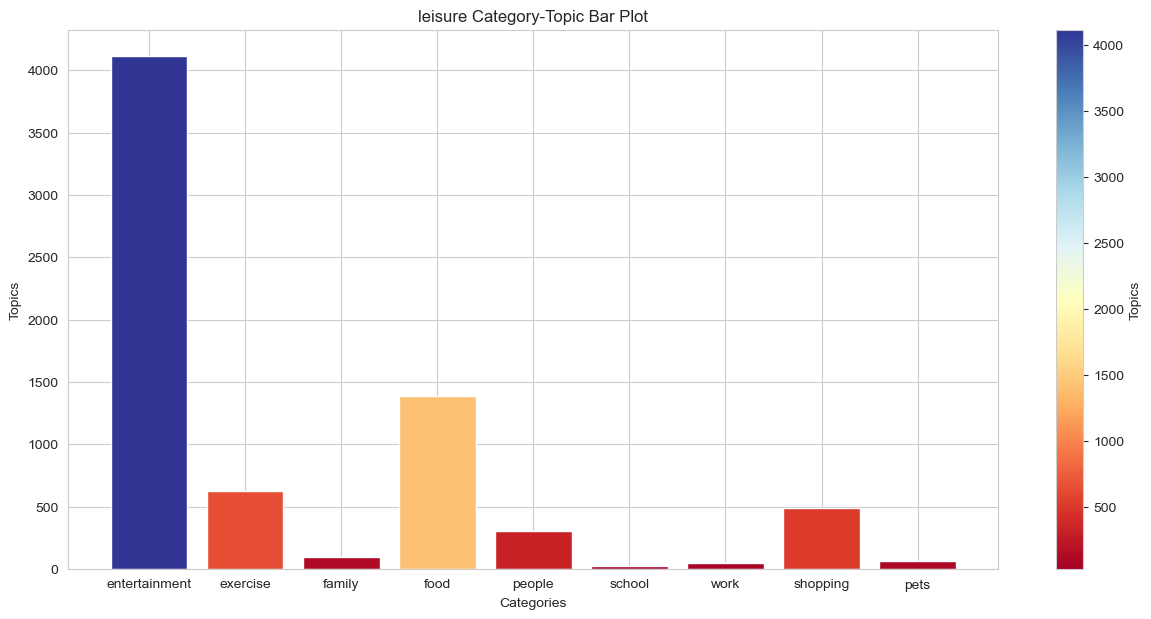

C:\Users\10168\AppData\Local\Temp\ipykernel_12672\657828276.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


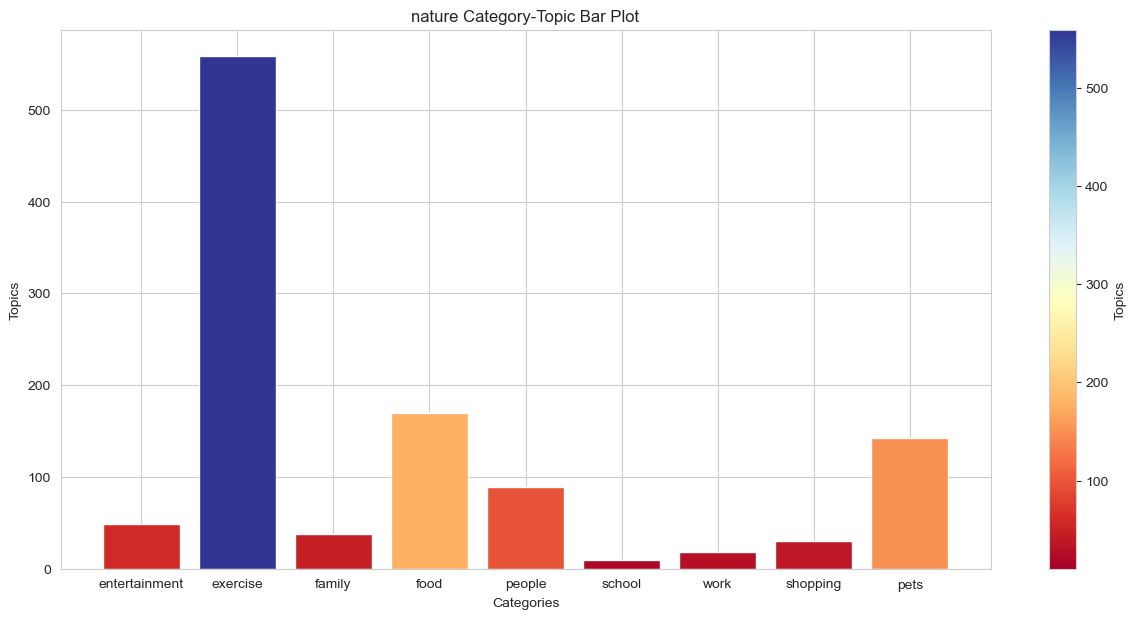

C:\Users\10168\AppData\Local\Temp\ipykernel_12672\657828276.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


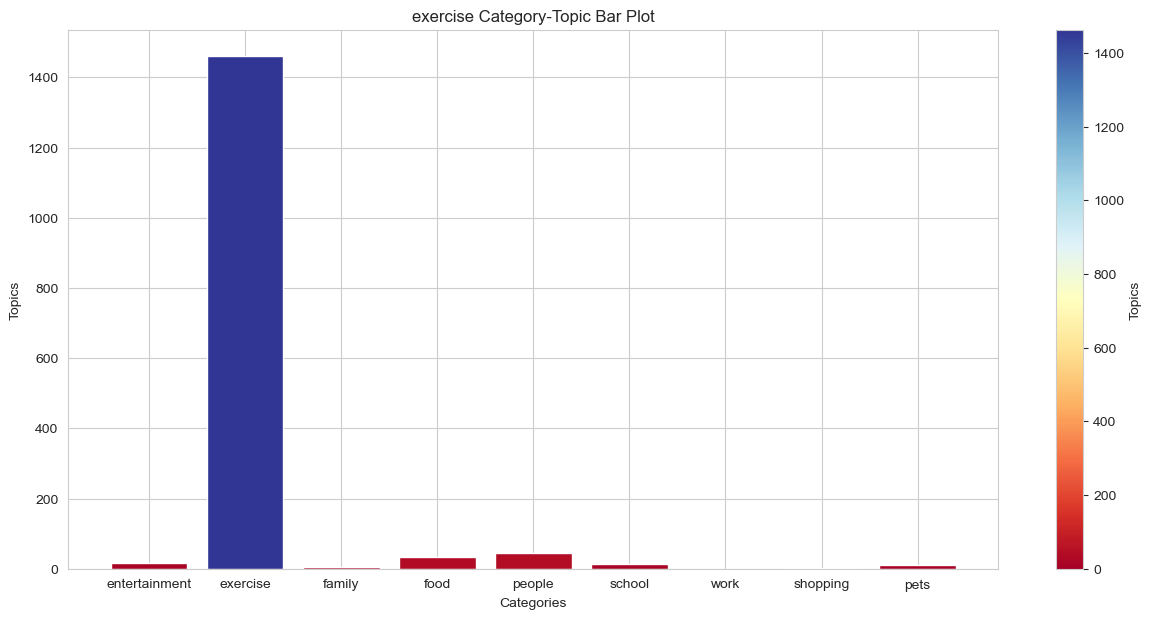

In [11]:
for category in ['affection', 'achievement', 'enjoy_the_moment', 'bonding', 'leisure', 'nature', 'exercise']:
    tem = df[df['predicted_category']==category]
    categories = list(tem.iloc[:, -9:].sum().to_dict().keys())
    values = list(tem.iloc[:, -9:].sum().to_dict().values())
    cmap = plt.get_cmap('RdYlBu')
    colors = [cmap(value / max(values)) for value in values]
    plt.figure(figsize=(15, 7))
    plt.bar(categories, values, color=colors)
    plt.title('{} Category-Topic Bar Plot'.format(category))
    plt.xlabel('Categories')
    plt.ylabel('Topics')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Topics')
    plt.savefig(os.path.join('../figs', '{} Category-Topic Bar Plot.png'.format(category)), dpi=300, bbox_inches='tight')
    plt.show()

# What makes people happy based on marital

## What makes people with different emotional states the happiest?
Word Cloud for different marital status


**1.Single:**  

**Freedom and Independence:** Individuals in the single category often prioritize freedom and independence, allowing them to pursue personal goals and interests without constraints.
**Social Diversity:** Being single may afford individuals opportunities to diversify their social circles and engage in a variety of social activities, leading to a rich array of happy experiences.  

**2.Married:**  

**Stable Partnership:** Married individuals may find happiness in the stability and support provided by their marital relationships. A strong partnership can offer emotional support and a sense of security.
**Family Satisfaction:** Family life, shared goals, and responsibilities within marriage may contribute to a sense of fulfillment and happiness.  

**3.Divorced:**  

**Self-Rediscovery:** Divorced individuals often embark on journeys of self-discovery, reclaiming personal interests and aspirations. The newfound freedom post-divorce can present new opportunities and experiences.
**Personal Growth:** Overcoming the challenges of divorce and redefining one's life direction can foster resilience and personal growth, leading to a sense of empowerment and fulfillment.  

**4.Widowed:**  

**Preservation of Fond Memories:** Widowed individuals may derive happiness from cherishing fond memories of their deceased spouses. Gratitude and appreciation for the past can serve as sources of happiness.
**Seeking New Meaning:** Following bereavement, individuals may seek new avenues for finding meaning and purpose in life, paving the way for reestablishing happiness.  

**5.Separated:**  

**Anticipation and Adjustment:** Separation often accompanies anticipation and adjustment, with uncertainties potentially causing emotional fluctuations. Individuals may find happiness through adapting to new lifestyles and circumstances.

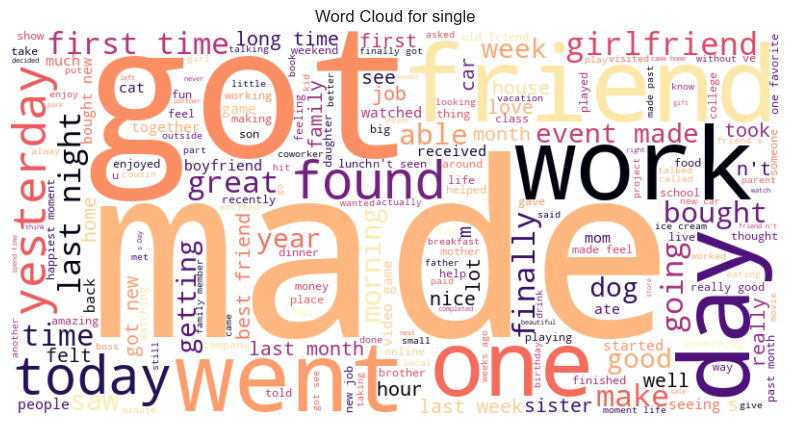

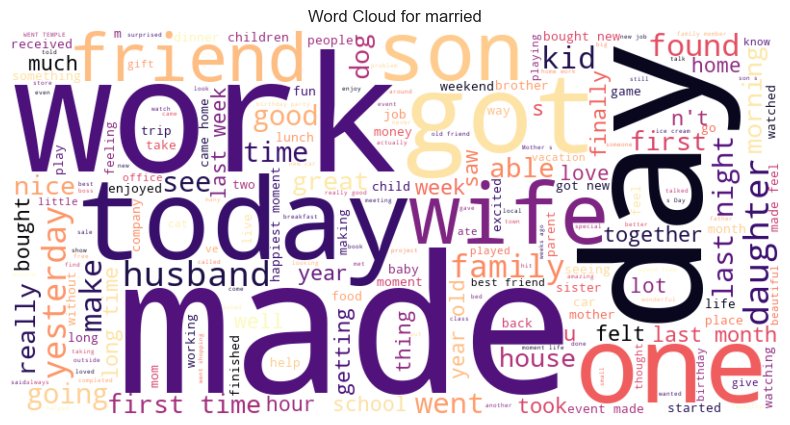

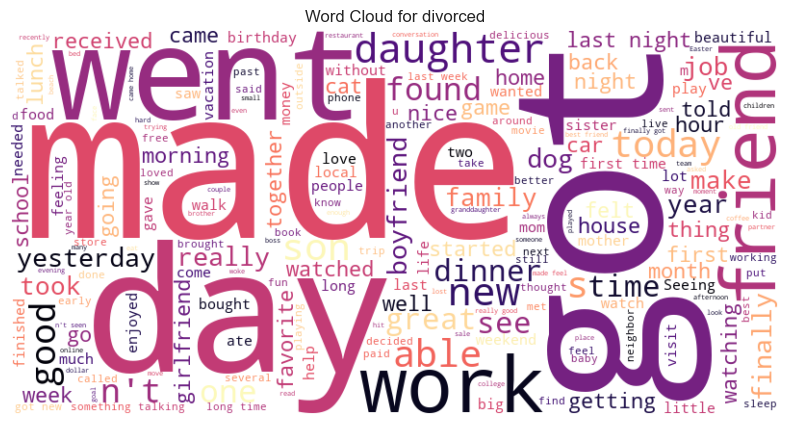

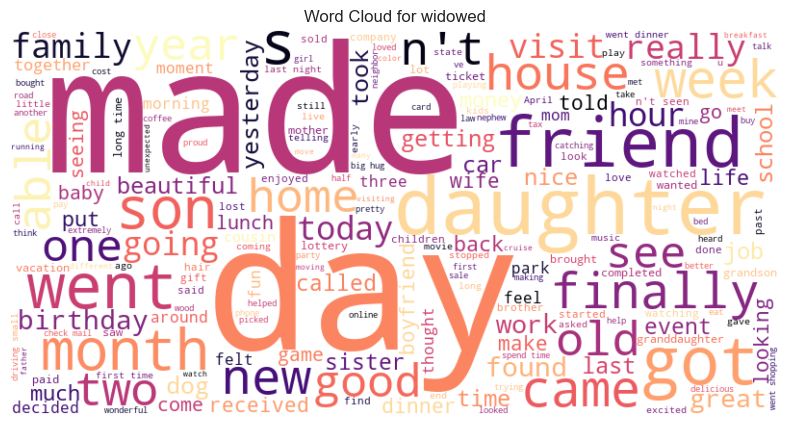

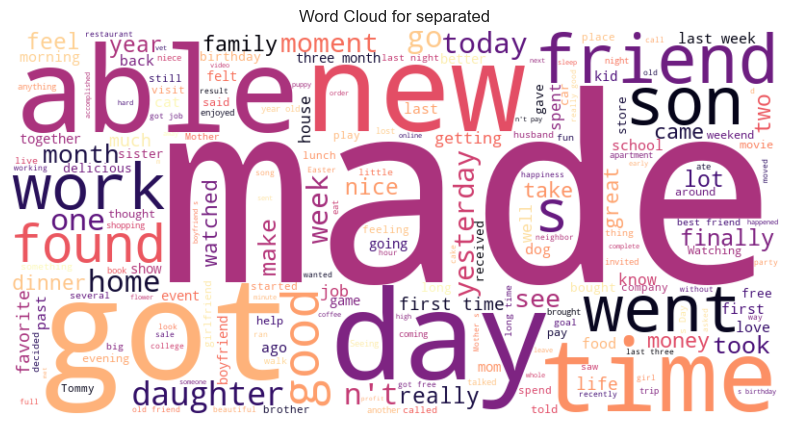

In [12]:
for i in list(df['marital'].unique())[:-1]:
    all_words = ' '.join([word for sublist in df[df['marital']==i]['f_tokens'] for word in sublist])
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='magma').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for {}'.format(i))
    plt.axis('off') 
    plt.savefig(os.path.join('../figs', 'Word Cloud for {}'.format(i)), dpi=300, bbox_inches='tight')
    plt.show()

## What changes in happiness do marriages bring to men and women separately?
Word Cloud for single and divorced based on different marital status
(Due to the limited sample size in other genders, only male and female studies were conducted)

**1.Single Individuals:**  

Men:

**Transition to Companionship:** Marriage often represents a transition from solitary living to companionship for single men, leading to increased emotional stability and social connectedness.
**Fulfillment of Social Roles:** Married men may find fulfillment in fulfilling societal expectations of partnership and family, contributing to a sense of purpose and happiness.

Women:

**Emotional Satisfaction:** For single women, marriage may offer emotional fulfillment and intimacy, addressing their desire for emotional connection and support.
**Security and Stability:** Marriage can provide a sense of security and stability for single women, alleviating concerns about the future and fostering overall happiness.
  
**2.Divorced Individuals:**

Men:

**Adjustment Challenges:** Divorced men may initially face challenges adjusting to single life, particularly if accustomed to the companionship of marriage. However, they may eventually find happiness in newfound freedom and autonomy.
**Opportunities for Personal Growth:** Divorce can spur personal growth and self-discovery for men, empowering them to redefine their identities and priorities, leading to increased happiness.

Women:

**Emotional Resilience:** Divorced women may navigate initial emotional turmoil with resilience, drawing strength from their experiences to forge new paths and find happiness on their own terms.
**Rediscovery of Independence:** Divorce may prompt women to reclaim their independence and autonomy, enabling them to pursue personal goals and aspirations, contributing to a sense of fulfillment and happiness.

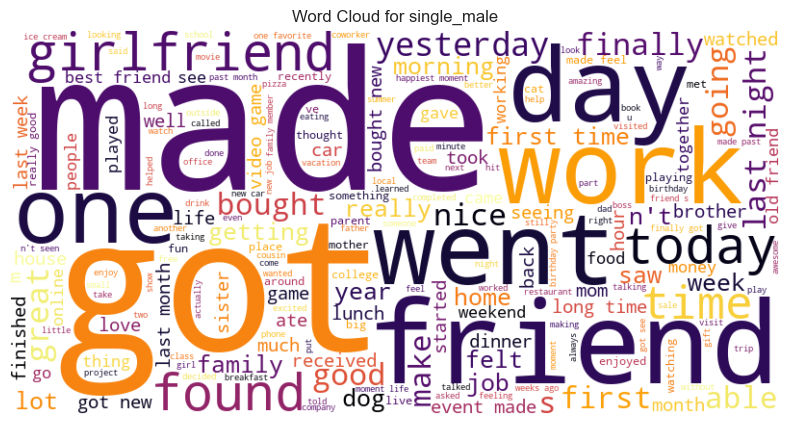

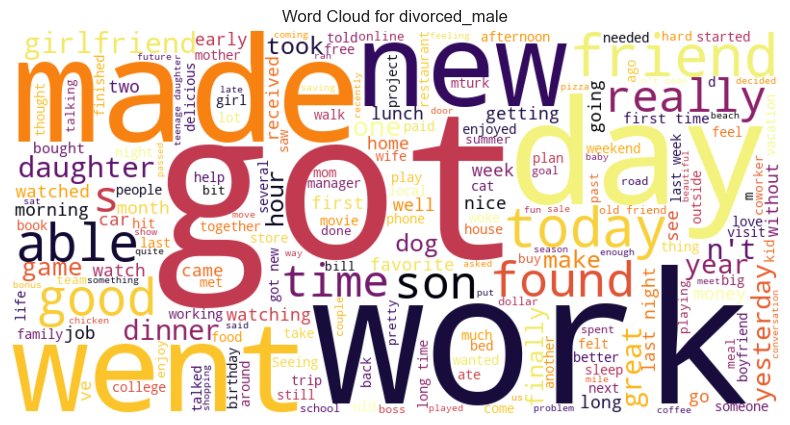

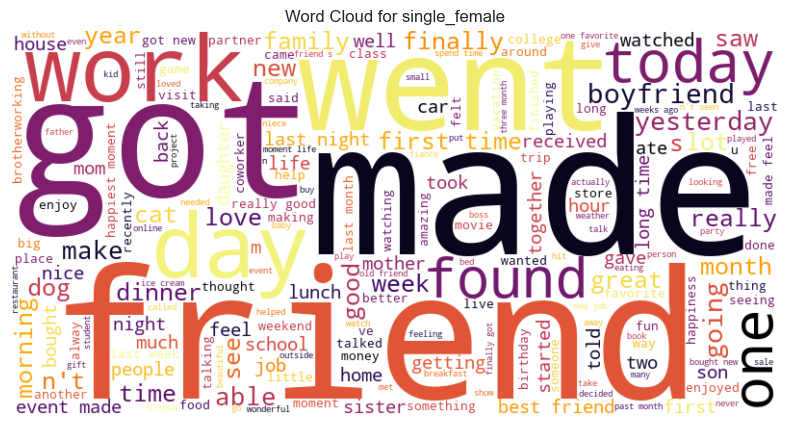

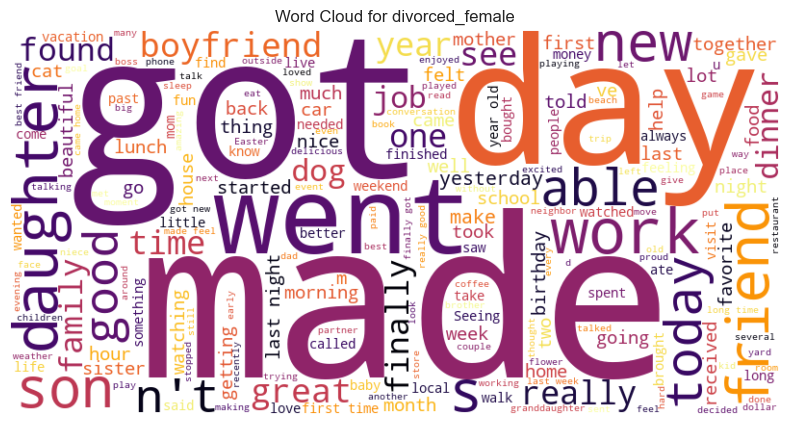

In [13]:
for i in range(2):
    for j in ['single','divorced']:
        all_words = ' '.join([word for sublist in df[(df['marital'] == '{}'.format(j)) & (df['gender'] == '{}'.format(df['gender'].unique()[i]))]['f_tokens'] for word in sublist])
        wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='inferno').generate(all_words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud for {}_{}'.format(j,['male','female'][i]))
        plt.axis('off')
        plt.savefig(os.path.join('../figs', 'Word Cloud for {}_{}'.format(j,['male','female'][i])), dpi=300, bbox_inches='tight')
        plt.show()